# Soiaporn model

Prototype the Metropolis-within-Gibbs sampling technique presented in Soiaporn et al. 2012.

The full conditionals:

$$
F_T | f, \lambda, D \sim Gamma \bigg(N_C +1, \frac{1}{1/s + (1 - f)\epsilon_0 + f \sum_{k \geq 1} w_k \epsilon_k}\bigg)
$$

$$
P(\lambda_i | F_T, f, D) \propto \frac{f_{\lambda_i}}{\epsilon_{\lambda_i}} h_{\lambda_i}
$$

Where $h_{j} = (1 - f) \epsilon_0$ if $j = 0$ and $h_j = fw_j\epsilon_j$ if $j \geq 1$.

$$
P(f | \lambda, F_T, D) \propto e^{-F_T [  (1 - f)\epsilon_0  + f \sum_{k \geq 1} \epsilon_k w_k] } \times (1-f)^{m_0(\lambda) + b - 1}f^{N_C - m_0(\lambda)+a-1}
$$


$F_T$ and $\lambda$ are sampled directly from the gamma and multinomial distributions. $f$ is sampled using a random walk Metropolis algorithm with Gaussian proposals centred on the current value of $f$. The variance of the proposal distribution was tuned to give an acceptance rate of 25%.

$\kappa$ is treated specially, they consider a logarithmically spaced grid of values to condition on. So, treat $\kappa$ as fixed. 

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import sys
sys.path.append('../fancy')
from fancy import Data
from fancy.detector.auger import A1, A2, A3, A, deltat, alpha_T
import pystan
import seaborn as sns
from metropolis_within_gibbs import *

## Set up

Define input parameters and data. NB: $\alpha_T = 20370 km^2 sr year$ is defined in `soiaporn_functions.py`.

In [12]:
# fixed parameters
#kappa = 100
kappa_c = 9323

# hyperparametrs
a = 1 
b = a
s = 0.01 * 4 * np.pi

#print(A1, A2, A3, A, alpha_T, deltat)

247.28036317426773 481.6602471763195 664.861996068412 458.75189079837014 20370 5.9986310746064335


In [13]:
# load data
uhecr_file = 'data/augerUHECR_data2010.dat'
source_file = 'data/agn_catalog.dat'

data = Data()
data.add_source(source_file, 'AGN')
data.add_uhecr(uhecr_file, 'Auger2010')

N_C = len(data.uhecr.energy)
theta = np.deg2rad(data.uhecr.incidence_angle)
d = data.uhecr.unit_vector
varpi = data.source.unit_vector
D = data.source.distance
period = data.uhecr.period
A = data.uhecr.A

In [15]:
# integral tables
from fancy.interfaces.integration import ExposureIntegralTable
from fancy.detector.auger import M, alpha_T, auger_params

my_table_file = 'tableforfig4.data.R'

params = auger_params

kappa = [10, 31.6, 100, 316, 1000]

#my_table = ExposureIntegralTable(kappa, varpi, params, filename = my_table_file)
#my_table.build()

eps = np.transpose(pystan.read_rdump(my_table_file)['table'])

## Recreate Fig. 4 in Soiaporn et al. 

Find the marginal posterior of $f$ for the different values of $\kappa$: [10, 31.6, 100, 316, 1000]. Use all the UHECR data.

In [17]:
sample_set = []
samplers = []
#for i in range(len(kappa)):

kappa = 10
eps_k = eps[0]

input_data = InputData(d, A, theta, varpi, D, eps_k)
#input_parameters = InputParameters(kappa, kappa_c, a, b, s)
#sampler = MetropolisWithinGibbs(input_data, input_parameters)
#sampler.Sample(Niter = 3000, Nchain = 2)

#sample_set.append(sampler.total_samples)
#samplers.append(sampler)

[3233.64537508 2684.17070829 1078.96785771 1670.24009935 3002.47485288
 2878.94499582 2766.59095747 1107.00397195 1081.3454526   156.58025737
 3078.98620953  297.62317609 2974.37903884  123.30631953  122.50576066
 2994.47498962 3249.955904  ]


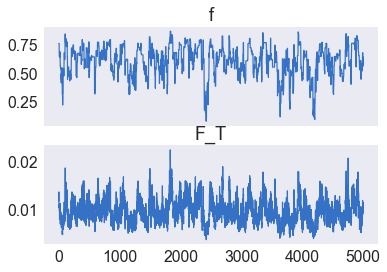

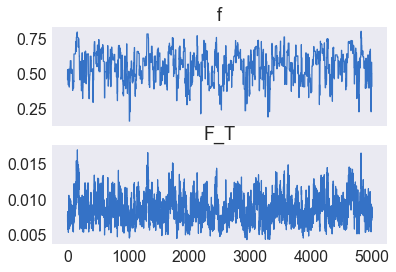

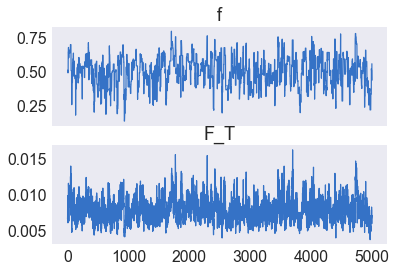

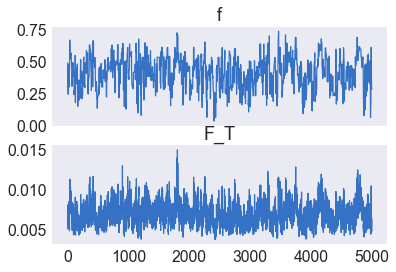

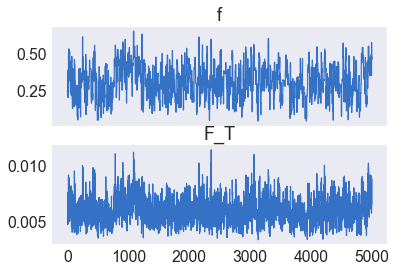

In [6]:
sns.set_style("dark")
for s in samplers:
    s.traceplot()

In [12]:
sampler.neff.F_T

271.3556268119861

/Users/fran/projects/bayes/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


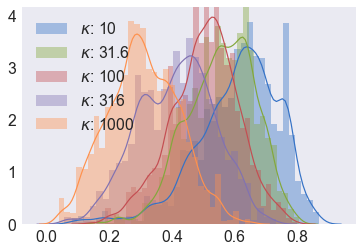

In [7]:
# plot
for i in range(len(sample_set)):
    sns.distplot(sample_set[i].f, label = '$\kappa$: ' + str(kappa[i]))
plt.legend()

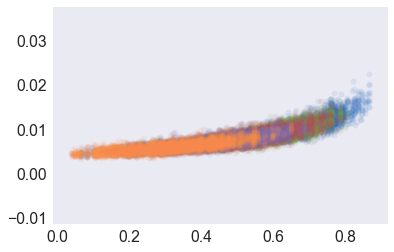

In [9]:
for i in range(len(sample_set)):
    plt.scatter(sample_set[i].f, sample_set[i].F_T, alpha = 0.1)